<a href="https://colab.research.google.com/github/ZakariaRekhla2004/image-detection-transformer/blob/main/image_detection_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from transformers import AutoImageProcessor
from transformers.models.detr import DetrForSegmentation

img_proc = AutoImageProcessor.from_pretrained(
    "cmarkea/detr-layout-detection"
)
model = DetrForSegmentation.from_pretrained(
    "cmarkea/detr-layout-detection"
)

img: PIL.Image

with torch.inference_mode():
    input_ids = img_proc(img, return_tensors='pt')
    output = model(**input_ids)

threshold=0.4

segmentation_mask = img_proc.post_process_segmentation(
    output,
    threshold=threshold,
    target_sizes=[img.size[::-1]]
)

bbox_pred = img_proc.post_process_object_detection(
    output,
    threshold=threshold,
    target_sizes=[img.size[::-1]]
)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/802 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

NameError: name 'PIL' is not defined

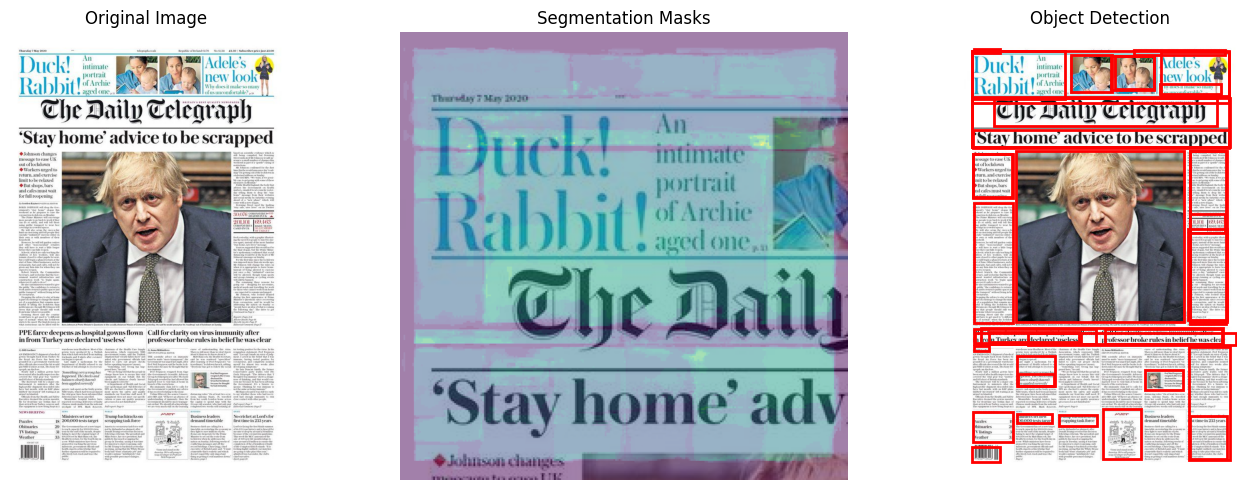

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoImageProcessor, DetrForSegmentation

def process_image(image_path, threshold=0.4):
    """
    Process an image using DETR layout detection model

    Args:
        image_path (str): Path to the input image
        threshold (float, optional): Confidence threshold for detection. Defaults to 0.4.

    Returns:
        tuple: Segmentation masks and bounding boxes
    """
    # Load the image
    img = Image.open(image_path).convert("RGB")

    # Initialize image processor and model
    img_proc = AutoImageProcessor.from_pretrained("cmarkea/detr-layout-detection")
    model = DetrForSegmentation.from_pretrained("cmarkea/detr-layout-detection")

    # Prepare input for the model
    with torch.inference_mode():
        input_ids = img_proc(img, return_tensors='pt')
        output = model(**input_ids)

    # Post-process segmentation masks
    segmentation_masks = output.pred_masks.sigmoid() > threshold

    # Post-process bounding boxes
    bbox_pred = img_proc.post_process_object_detection(
        output,
        threshold=threshold,
        target_sizes=[img.size[::-1]]
    )

    return segmentation_masks, bbox_pred, img

def visualize_results(img, segmentation_masks, bbox_pred):
    """
    Visualize the segmentation masks and bounding boxes

    Args:
        img (PIL.Image): Original image
        segmentation_masks (torch.Tensor): Segmentation masks
        bbox_pred (list): Bounding box predictions
    """
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.axis('off')

    # Segmentation Masks
    plt.subplot(1, 3, 2)
    plt.title("Segmentation Masks")

    # Create a combined segmentation mask visualization
    combined_mask = torch.zeros_like(segmentation_masks[0][0], dtype=torch.float)
    for i, mask in enumerate(segmentation_masks[0]):
        combined_mask += mask.float() * ((i + 1) / len(segmentation_masks[0]))

    plt.imshow(img)
    plt.imshow(combined_mask, cmap='viridis', alpha=0.5)
    plt.axis('off')

    # Bounding Boxes
    plt.subplot(1, 3, 3)
    plt.title("Object Detection")
    plt.imshow(img)

    for pred in bbox_pred:
        scores = pred['scores']
        boxes = pred['boxes']

        for score, box in zip(scores, boxes):
            box = box.numpy()
            plt.gca().add_patch(plt.Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                fill=False,
                edgecolor='red',
                linewidth=2
            ))

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
def main():
    # Replace 'path/to/your/image.jpg' with the actual path to your image
    image_path = '/content/R.jpg'

    # Process the image
    segmentation_masks, bbox_pred, img = process_image(image_path)

    # Visualize results
    visualize_results(img, segmentation_masks, bbox_pred)

if __name__ == "__main__":
    main()

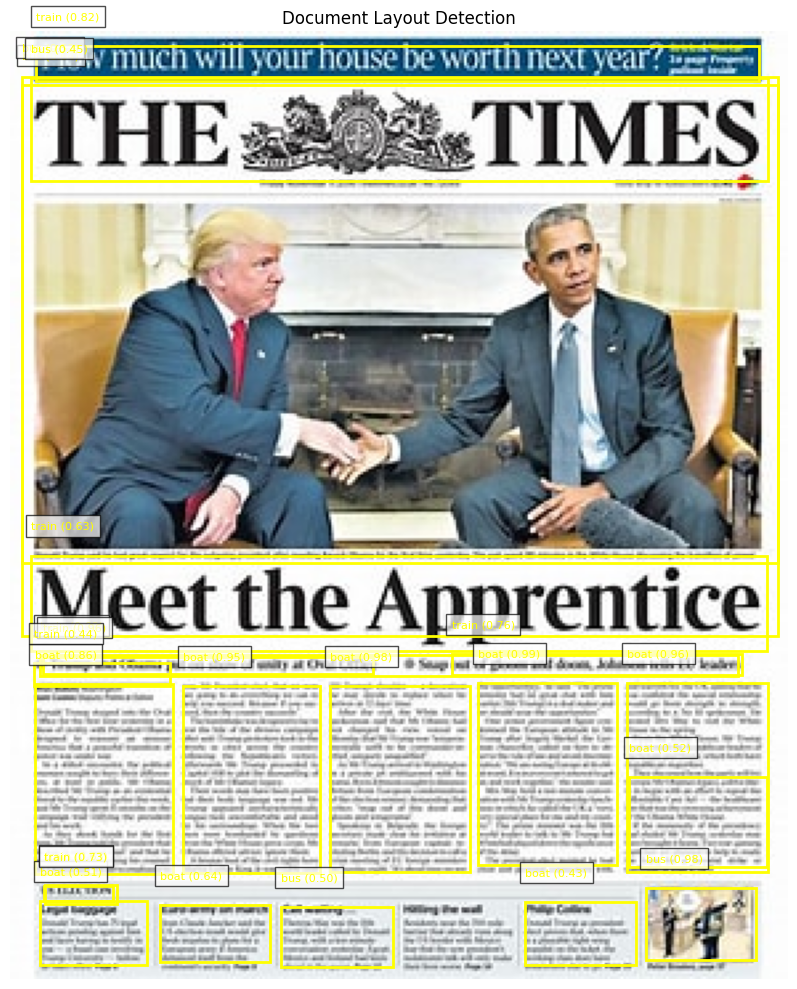

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoImageProcessor, DetrForSegmentation

# COCO classes for DETR layout detection
COCO_CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
    'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
    'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet',
    'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

def process_image(image_path, threshold=0.4):
    """
    Process an image using DETR layout detection model

    Args:
        image_path (str): Path to the input image
        threshold (float, optional): Confidence threshold for detection. Defaults to 0.4.

    Returns:
        tuple: Segmentation masks, bounding boxes, original image, and labels
    """
    # Load the image
    img = Image.open(image_path).convert("RGB")

    # Initialize image processor and model
    img_proc = AutoImageProcessor.from_pretrained("cmarkea/detr-layout-detection")
    model = DetrForSegmentation.from_pretrained("cmarkea/detr-layout-detection")

    # Prepare input for the model
    with torch.inference_mode():
        input_ids = img_proc(img, return_tensors='pt')
        output = model(**input_ids)

    # Post-process bounding boxes
    bbox_pred = img_proc.post_process_object_detection(
        output,
        threshold=threshold,
        target_sizes=[img.size[::-1]]
    )

    return bbox_pred[0], img

def visualize_layout(img, bbox_pred):
    """
    Visualize image layout with bounding boxes and labels

    Args:
        img (PIL.Image): Original image
        bbox_pred (dict): Bounding box predictions
    """
    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.title("Document Layout Detection")

    # Extract boxes, scores, and labels
    boxes = bbox_pred['boxes']
    scores = bbox_pred['scores']
    labels = bbox_pred['labels']

    # Sort boxes by area to ensure larger regions are drawn first
    box_data = []
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        area = (x2 - x1) * (y2 - y1)
        box_data.append((box, score, label, area))

    # Sort by area in descending order
    box_data.sort(key=lambda x: x[3], reverse=True)

    # Color map for different element types
    color_map = {
        'text': 'blue',
        'title': 'red',
        'figure': 'green',
        'table': 'purple',
        'list': 'orange'
    }

    for box, score, label, area in box_data:
        # Convert tensor to numpy if needed
        box = box.numpy() if hasattr(box, 'numpy') else box
        label_name = COCO_CLASSES[label]

        # Determine box color based on label or use a default color
        color = 'yellow'

        # Add bounding box
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            fill=False,
            edgecolor=color,
            linewidth=2
        )
        plt.gca().add_patch(rect)

        # Add label with score
        plt.text(
            box[0],
            box[1] - 10,
            f'{label_name} ({score:.2f})',
            color=color,
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.7)
        )

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
def main():
    # Replace with the path to your document or image
    image_path = '/content/th (1).jpg'

    # Process the image
    bbox_pred, img = process_image(image_path)

    # Visualize layout
    visualize_layout(img, bbox_pred)

if __name__ == "__main__":
    main()

In [ ]:
pip install   pillow  PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 33.0 MB/s eta 0:00:00


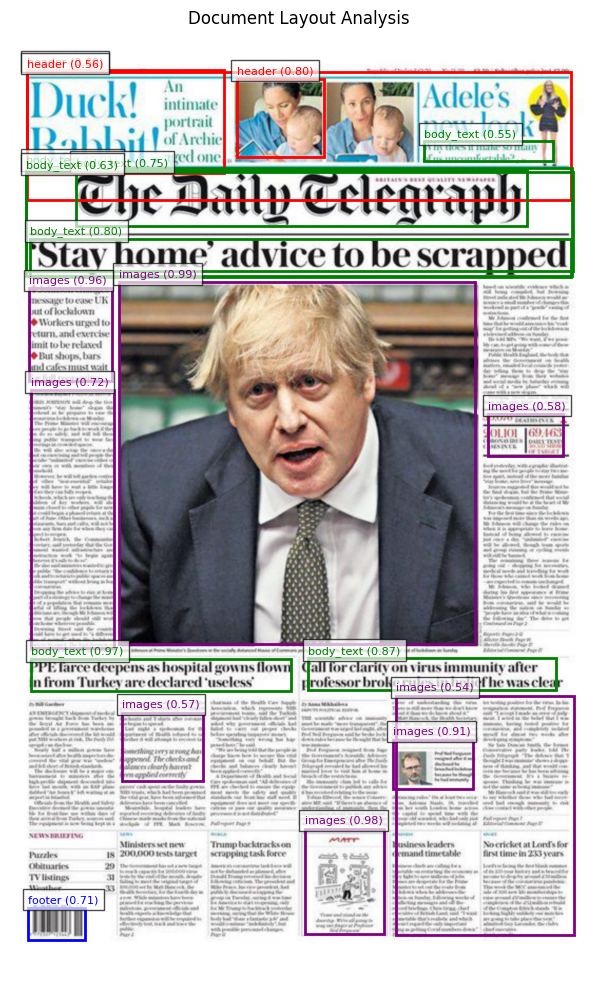

In [ ]:
import torch
import fitz  # PyMuPDF
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoImageProcessor, DetrForSegmentation

class PDFLayoutAnalyzer:
    def __init__(self, model_name="cmarkea/detr-layout-detection"):
        """
        Initialize PDF layout analyzer with DETR model

        Args:
            model_name (str): Pretrained model for layout detection
        """
        self.img_proc = AutoImageProcessor.from_pretrained(model_name)
        self.model = DetrForSegmentation.from_pretrained(model_name)

    def convert_pdf_to_images(self, pdf_path, zoom=2):
        """
        Convert PDF pages to images

        Args:
            pdf_path (str): Path to the PDF file
            zoom (int): Zoom level for image resolution

        Returns:
            list: List of page images
        """
        doc = fitz.open(pdf_path)
        page_images = []

        for page in doc:
            # Render page to an image
            pix = page.get_pixmap(matrix=fitz.Matrix(zoom, zoom))
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            page_images.append(img)

        return page_images

    def detect_layout_elements(self, image, threshold=0.5):
        """
        Detect layout elements in an image

        Args:
            image (PIL.Image): Input image
            threshold (float): Confidence threshold for detection

        Returns:
            dict: Detected layout elements with bounding boxes
        """
        # Prepare input for the model
        with torch.inference_mode():
            input_ids = self.img_proc(image, return_tensors='pt')
            output = self.model(**input_ids)

        # Post-process object detection
        bbox_pred = self.img_proc.post_process_object_detection(
            output,
            threshold=threshold,
            target_sizes=[image.size[::-1]]
        )[0]

        return bbox_pred

    def classify_document_elements(self, bbox_pred):
        """
        Classify and categorize document elements

        Args:
            bbox_pred (dict): Bounding box predictions

        Returns:
            dict: Categorized document elements
        """
        # Sort bounding boxes by vertical position
        sorted_boxes = sorted(
            zip(bbox_pred['boxes'], bbox_pred['scores'], bbox_pred['labels']),
            key=lambda x: x[0][1]  # Sort by y-coordinate
        )

        # Classify elements based on vertical position
        document_elements = {
            'header': [],
            'footer': [],
            'body_text': [],
            'images': []
        }

        image_height = max(box[0][3] for box in sorted_boxes)

        for box, score, label in sorted_boxes:
            x1, y1, x2, y2 = box
            area = (x2 - x1) * (y2 - y1)

            # Header (top 10% of page)
            if y1 < image_height * 0.1:
                document_elements['header'].append({
                    'box': box.numpy(),
                    'score': float(score),
                    'area': area
                })

            # Footer (bottom 10% of page)
            elif y1 > image_height * 0.9:
                document_elements['footer'].append({
                    'box': box.numpy(),
                    'score': float(score),
                    'area': area
                })

            # Images (based on size and aspect ratio)
            elif area > (image_height * 0.2) and (x2 - x1) / (y2 - y1) < 3:
                document_elements['images'].append({
                    'box': box.numpy(),
                    'score': float(score),
                    'area': area
                })

            # Body text (remaining areas)
            else:
                document_elements['body_text'].append({
                    'box': box.numpy(),
                    'score': float(score),
                    'area': area
                })

        return document_elements

    def visualize_layout(self, image, layout_elements):
        """
        Visualize document layout elements

        Args:
            image (PIL.Image): Original document image
            layout_elements (dict): Detected layout elements
        """
        plt.figure(figsize=(15, 10))
        plt.imshow(image)
        plt.title("Document Layout Analysis")

        # Color mapping for different elements
        color_map = {
            'header': 'red',
            'footer': 'blue',
            'body_text': 'green',
            'images': 'purple'
        }

        # Draw bounding boxes for each element type
        for element_type, elements in layout_elements.items():
            color = color_map.get(element_type, 'yellow')

            for element in elements:
                box = element['box']
                score = element['score']

                # Draw bounding box
                rect = plt.Rectangle(
                    (box[0], box[1]),
                    box[2] - box[0],
                    box[3] - box[1],
                    fill=False,
                    edgecolor=color,
                    linewidth=2
                )
                plt.gca().add_patch(rect)

                # Add label with score
                plt.text(
                    box[0],
                    box[1] - 10,
                    f'{element_type} ({score:.2f})',
                    color=color,
                    fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.7)
                )

        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def analyze_pdf(self, pdf_path, threshold=0.5):
        """
        Analyze entire PDF and visualize layout for each page

        Args:
            pdf_path (str): Path to the PDF file
            threshold (float): Confidence threshold for detection

        Returns:
            list: Layout analysis for each page
        """
        # Convert PDF to images
        page_images = self.convert_pdf_to_images(pdf_path)

        page_layouts = []

        # Analyze each page
        for page_image in page_images:
            # Detect layout elements
            bbox_pred = self.detect_layout_elements(page_image, threshold)

            # Classify document elements
            layout_elements = self.classify_document_elements(bbox_pred)

            # Visualize layout
            self.visualize_layout(page_image, layout_elements)

            page_layouts.append(layout_elements)

        return page_layouts

# Example usage
def main():
    # Replace with the path to your PDF
    pdf_path = '/content/R.jpg'

    # Create layout analyzer
    analyzer = PDFLayoutAnalyzer()

    # Analyze PDF
    page_layouts = analyzer.analyze_pdf(pdf_path)

if __name__ == "__main__":
    main()